# Statistical and systematic uncertainties in fitting

Originally developed by William Irvine for PHYS 211 (January 2016)

## Introduction 

This program generates mock data sets given a model, with adjustable statistical and systematic uncertainties.

The purpose is to both quantitiatively and graphically represent the effects of statistical and systematic uncertainties on a linear fit to data. This is accomplished by generating a pseudodata dataset that is assigned both statistical and systematic uncertainties. 

## Preliminaries

Import the appropriate libraries and define a few helper methods that provide linear functions and their residuals.

In [12]:
import numpy as np
from scipy import loadtxt, optimize
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [13]:
# simple linear function
def linear(p, x):
    """
    Creates a simple linear function
    
    Parameters
    ----------
    p: array of parameters
      p[0] is the y-intercept
      p[1] is the slope
    
    x: array of x-values at which to 
       evaluate the linear function
    """
    
    return p[0] + p[1]*x

In [14]:
# residual of a linear function 
def linear_residual(p, x, y, dy):
    """
    Computes the residuals for a simple linear function
    
    Parameters
    ----------
    p: array of parameters
      p[0] is the y-intercept
      p[1] is the slope
    
    x: array of x-values at which to 
       evaluate the linear function
       
    y: array of observed y-values
    
    dy: uncertainties on the observed y-values
    """
    
    return (linear(p,x)-y)/dy

In [15]:
# gaussian function
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [16]:
# values drawn from gaussian distribution
def gdist(N=100, mean=0, sigma=5):
    return sigma*np.random.randn(N)+mean

In [17]:
# generate a mock dataset: function func evaluated at x-values x, with standard deviations sigma 
def mockdata(x, sigma, func):
    """
    Generates a pseudodata dataset of y-values distributed according 
    to a Gaussian distribution, with a mean value given by evaluating 
    the function `func` at the corresponding x-values, `x`, and with
    standard deviations `sigma`.
    
    Parameters
    ----------
    x: array of x-values at which to 
       evaluate the function provided
      
    sigma: value or array of values of 
           uncertainties on y-values at 
           each x-value specified
       
    func: function that gives the y-value 
          on which to center a Gaussian 
          distribution of possible y-values
    """
    
    # if standard deviation is a single number - that is assigned to all points
    if np.size(sigma)==1:
        sigma = sigma*np.ones_like(x)
    
    # Initialize an array to hold the generated distribution of y-values 
    # based on a probability distribution function func
    yy=[]
    
    # otherwise each point can have a separate sigma
    err=sigma
    
    # loop over all of the x-values and generate a Gaussian distribution 
    # of y-values given by the `gdist` function with standard deviations
    # given by the uncertainty in the y-values specified by `sigma`
    for xi, si in zip(x,sigma):
        yy.append( gdist(N=1, mean=func(xi), sigma=si)[0] )
    
    yy = np.array(yy)
    
    # Return the array of y-values distributed according to a Gaussian 
    # distribution, with a mean value given by evaluating the function
    # `func` at the corresponding x-values
    return yy, err

In [19]:
# initialize array for collecting results of fits
results=[]

In [20]:
# x coordinates that specify the measurements
xvalues = np.array([0,2,3,4,5,8,30])

In [21]:
# Systematic uncertainties for each measurement point
systs = 2.0*np.array([1,3,4,7,-3,2,-5])

In [26]:
# Underlying ("true") standard deviations of values of the measurements at each point `x`
# These are what we will use to generate the distributions of possible measurements
true_error = np.array([2,2,2,3,3,3,1.5])

In [23]:
# Estimated errors (could be the same as the true errors, or not)
estimated_error = 1.0*true_error

In [24]:
# Specify the "true" model. That is, we define the y-intercept (p0[0]) and slope (p0[1]) of our linear system 
p0 = [2,3.3]

In [25]:
# Create a lambda function for handing to the mockdata
func = lambda x: linear(p0, x)
func_residual = linear_residual

None

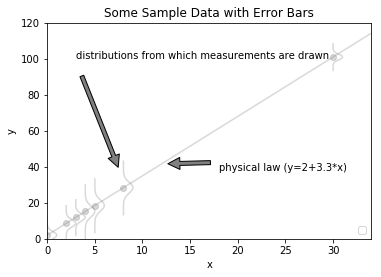

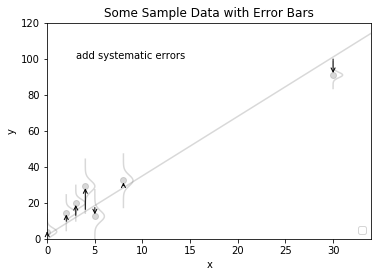

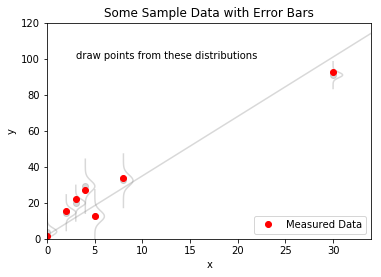

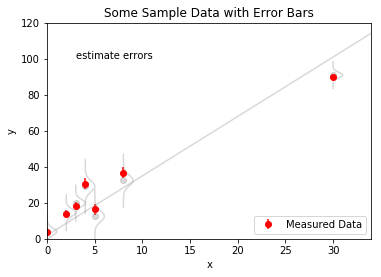

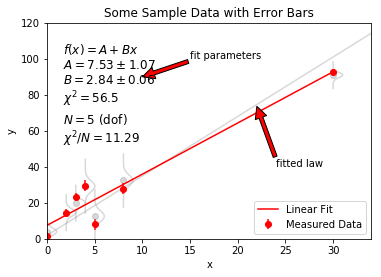

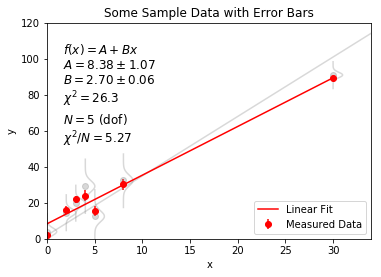

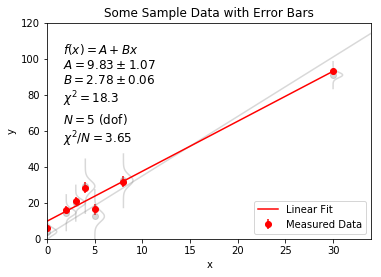

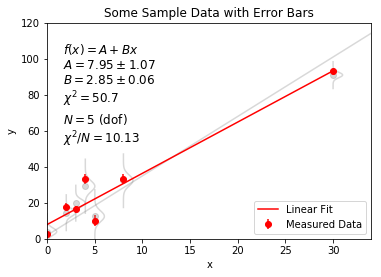

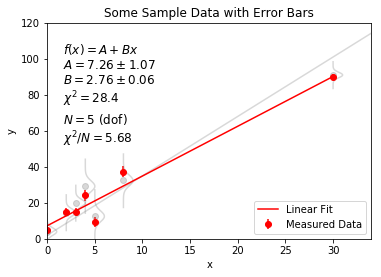

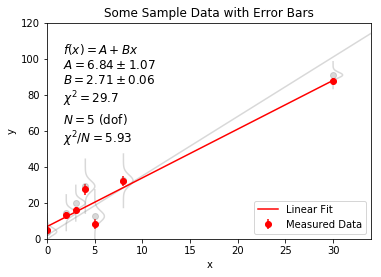

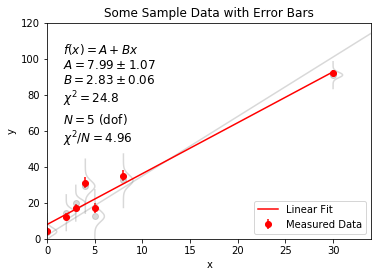

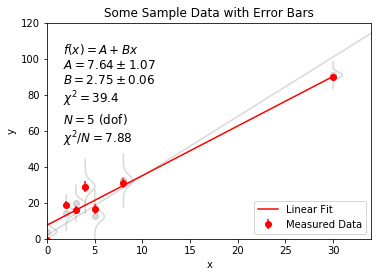

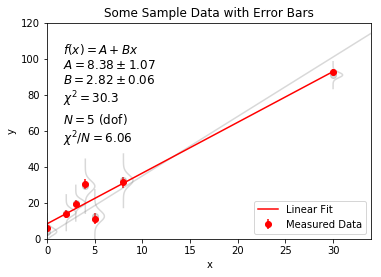

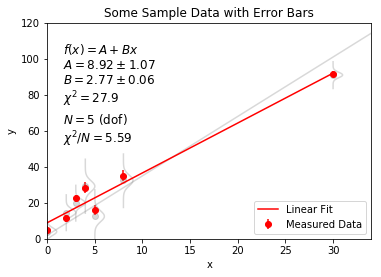

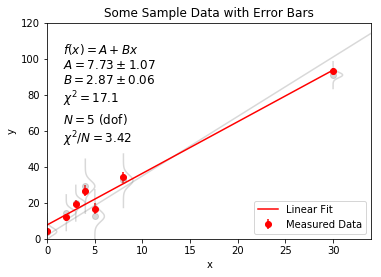

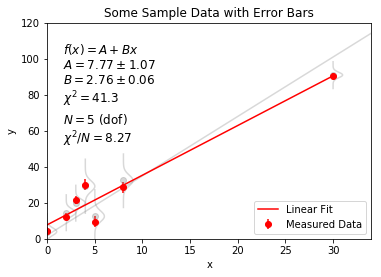

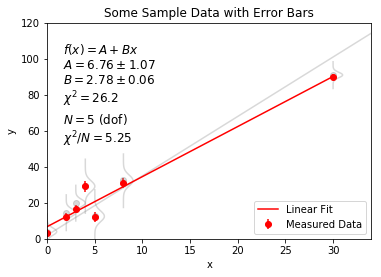

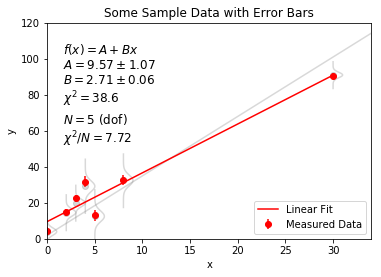

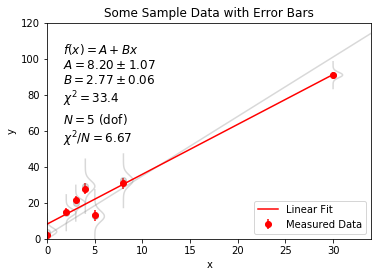

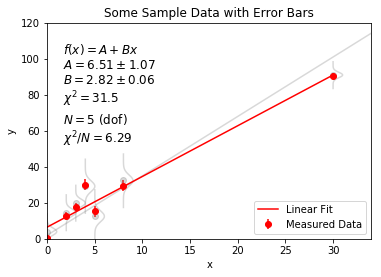

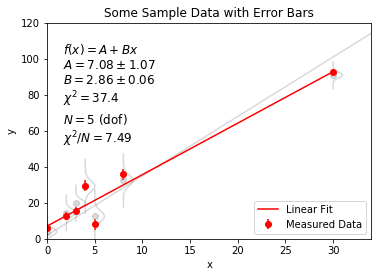

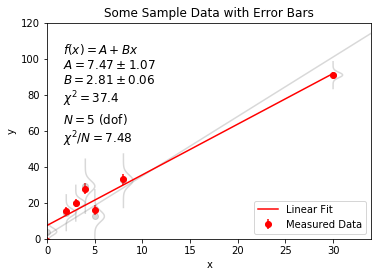

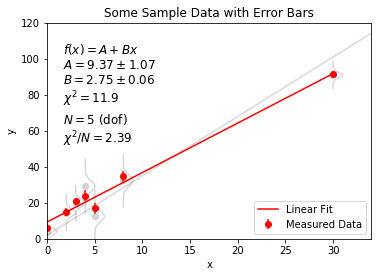

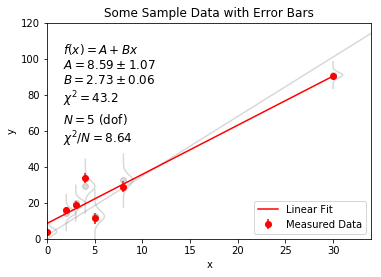

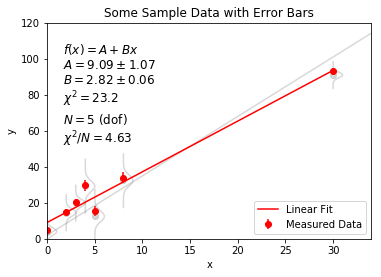

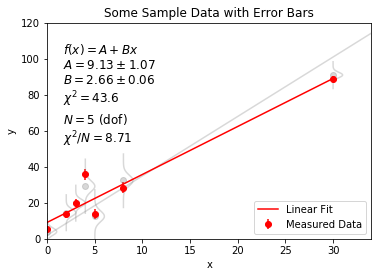

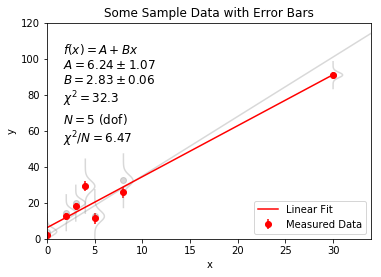

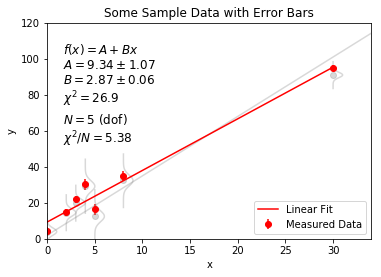

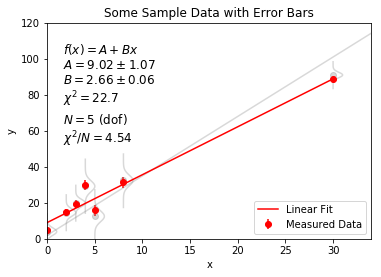

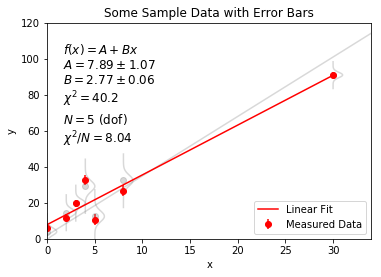

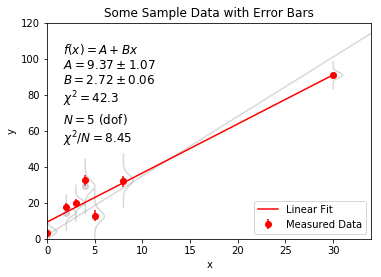

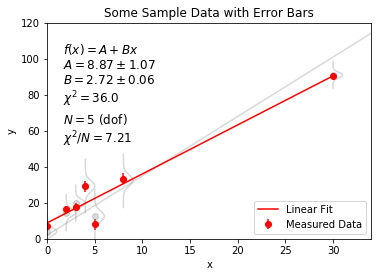

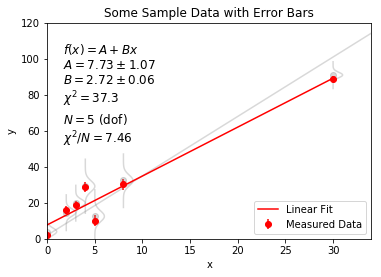

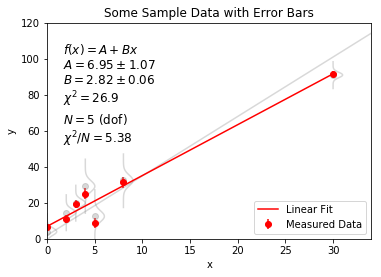

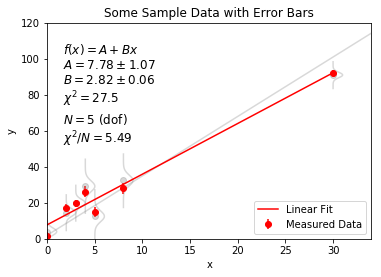

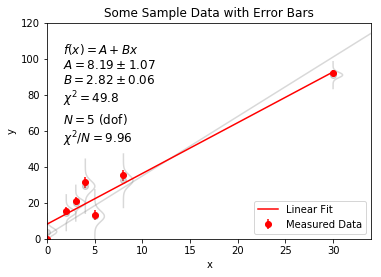

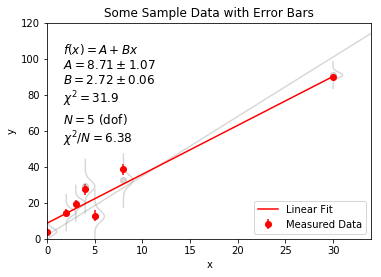

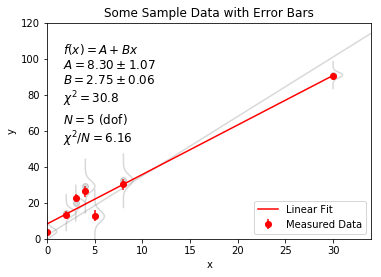

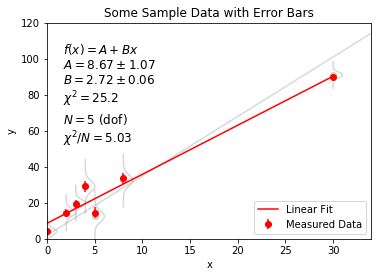

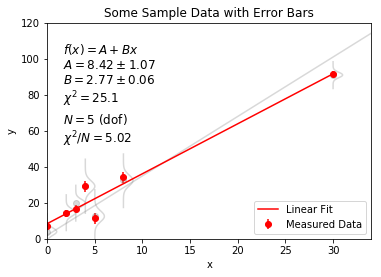

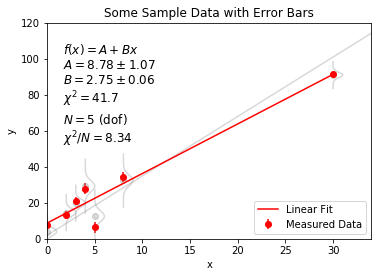

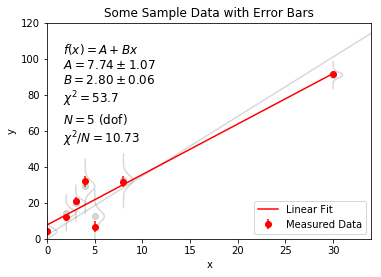

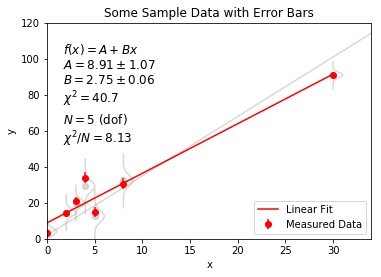

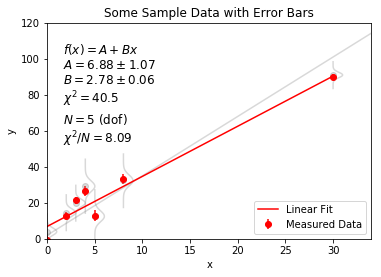

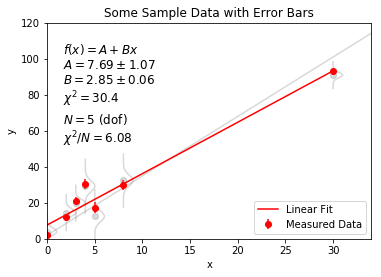

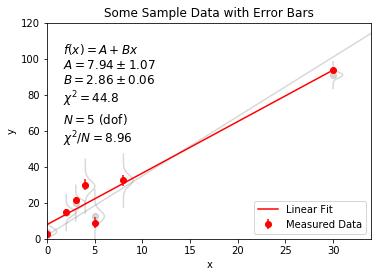

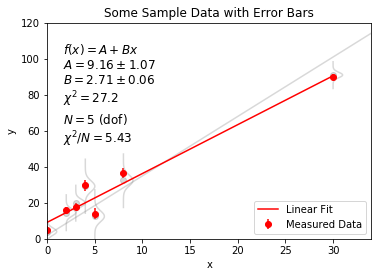

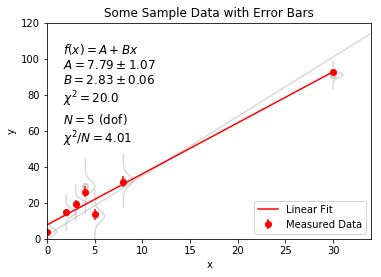

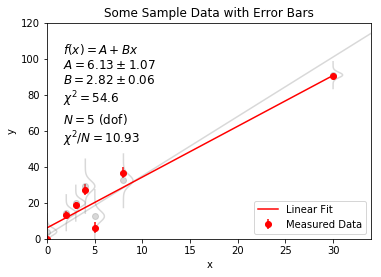

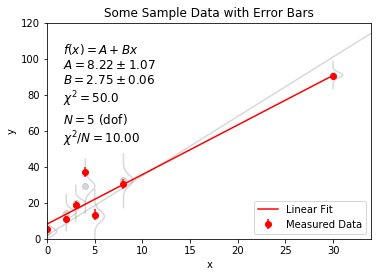

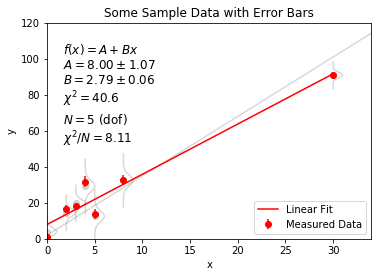

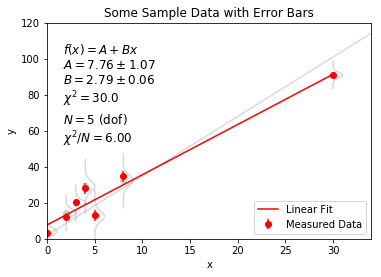

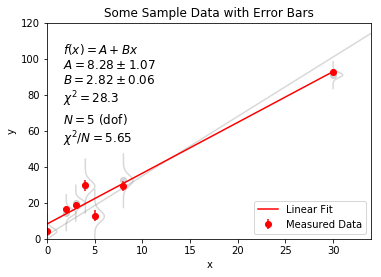

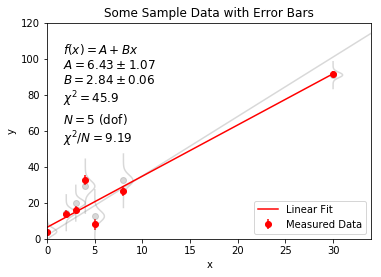

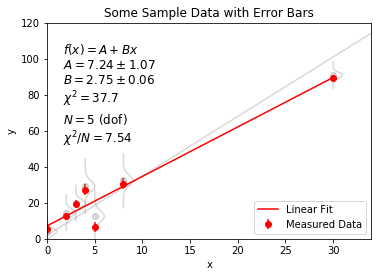

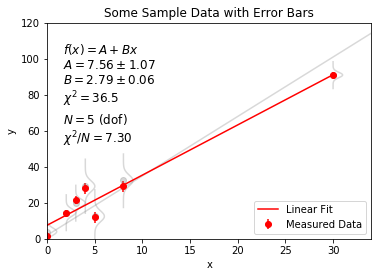

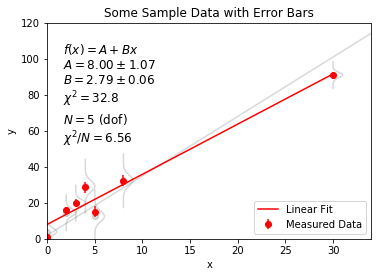

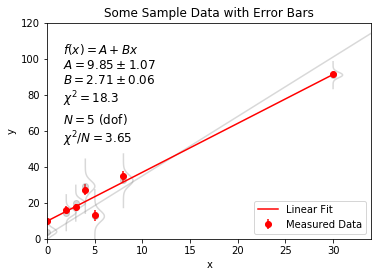

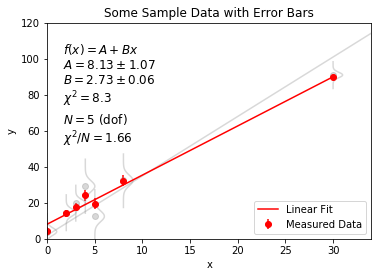

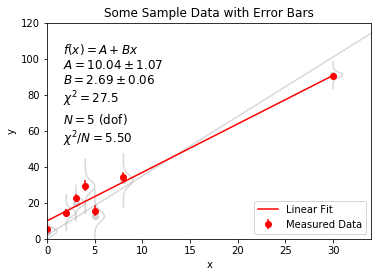

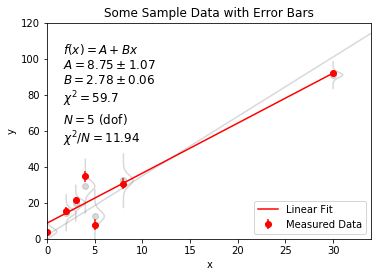

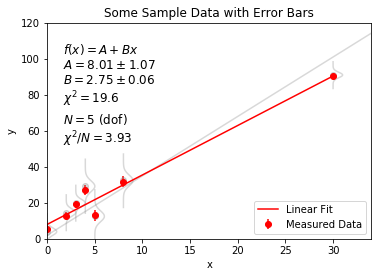

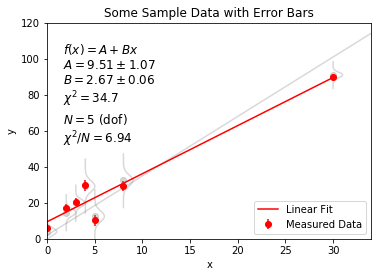

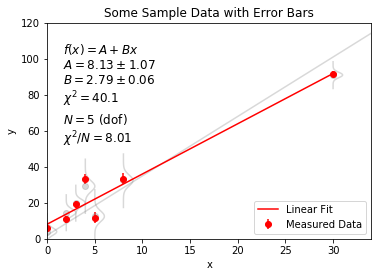

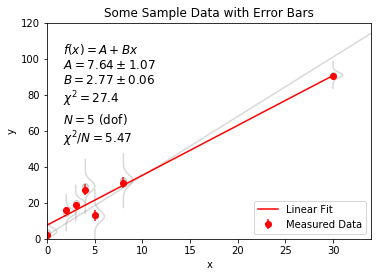

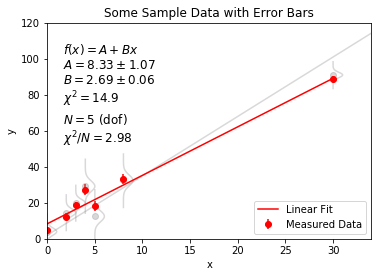

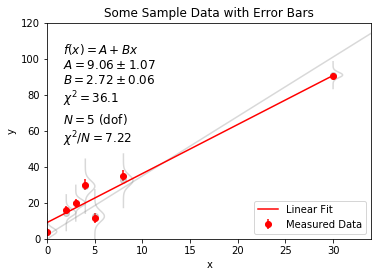

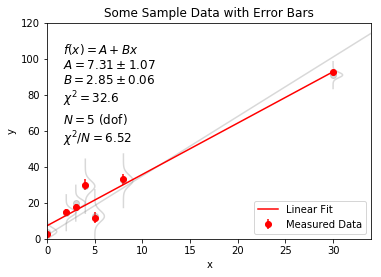

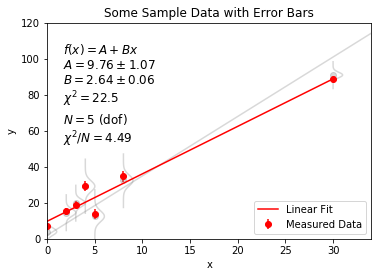

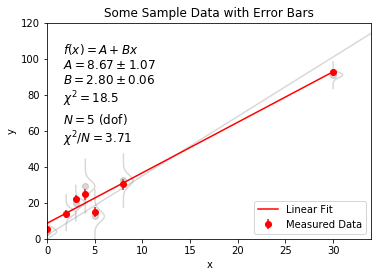

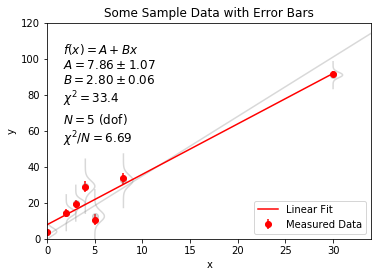

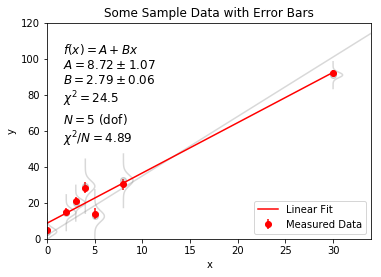

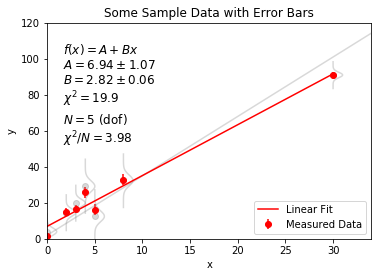

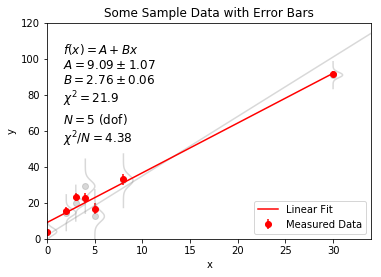

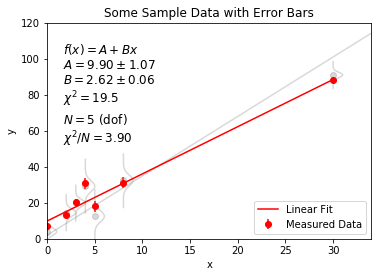

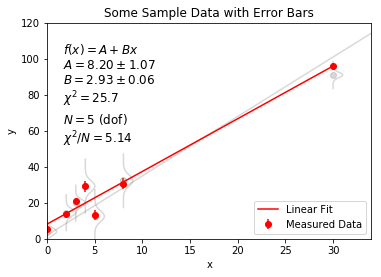

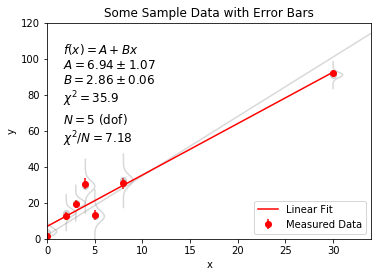

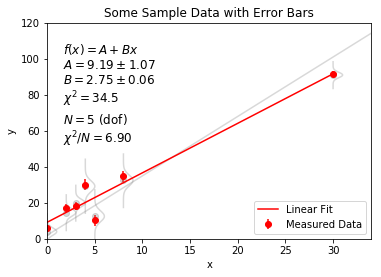

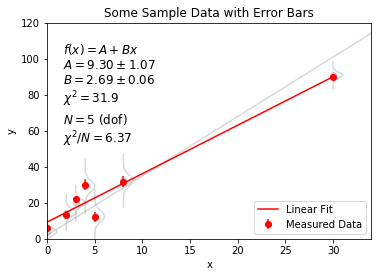

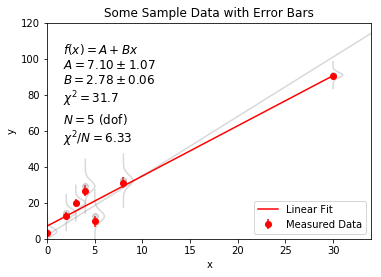

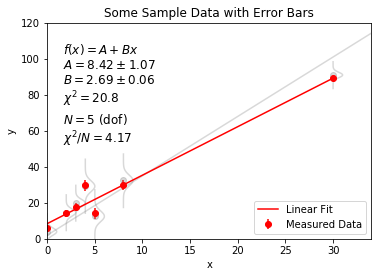

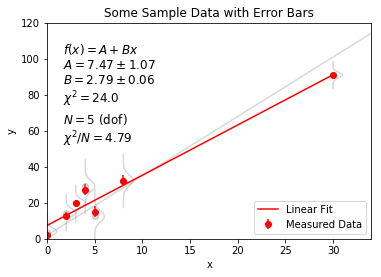

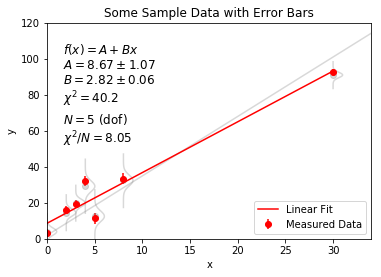

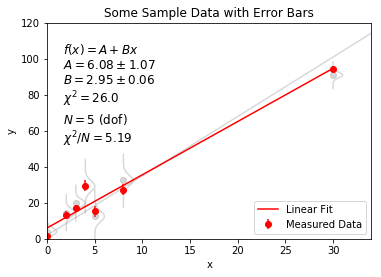

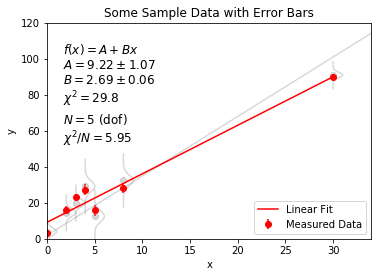

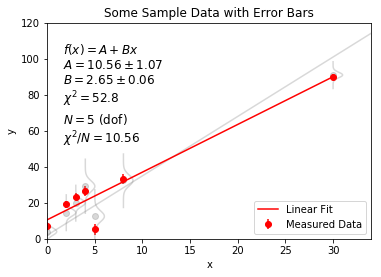

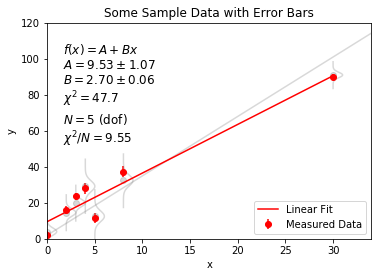

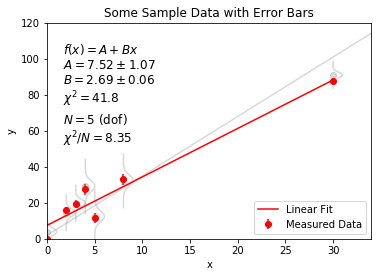

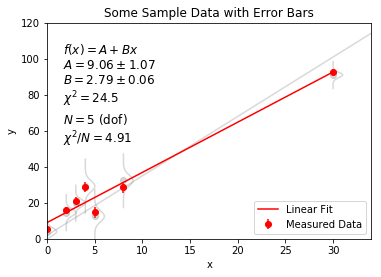

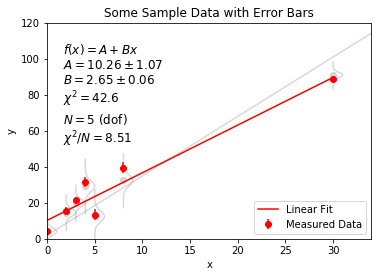

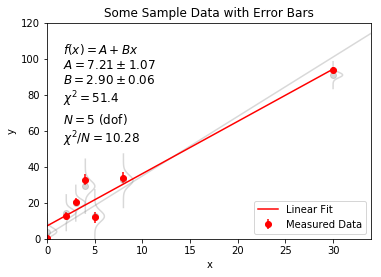

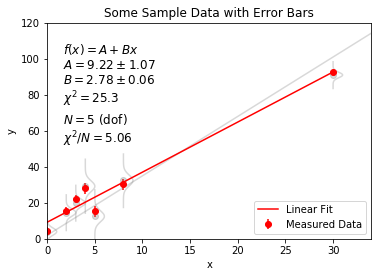

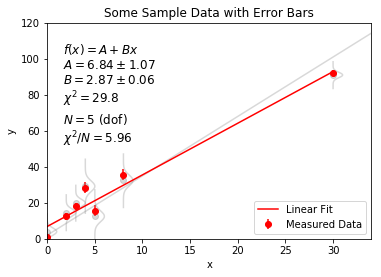

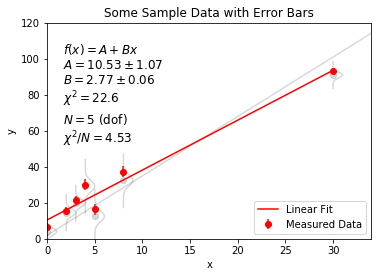

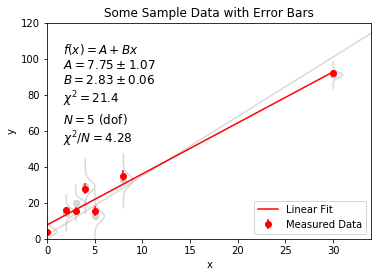

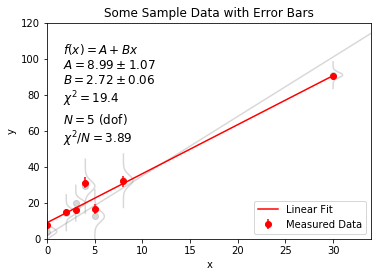

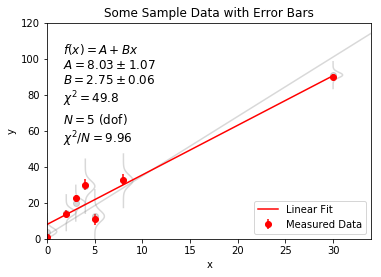

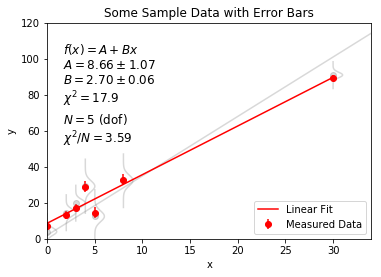

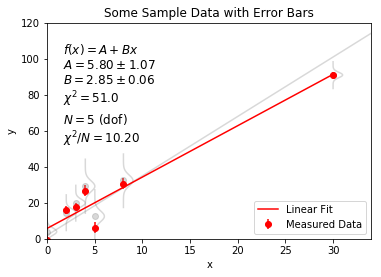

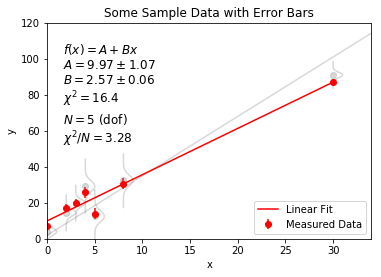

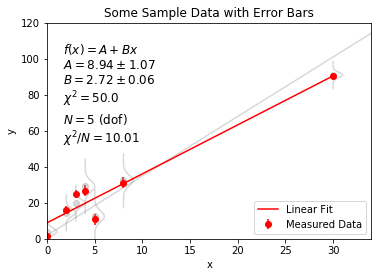

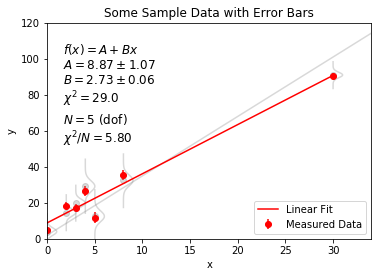

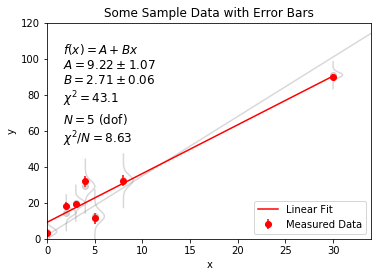

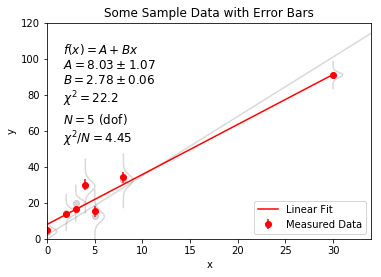

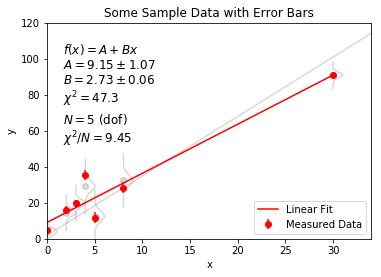

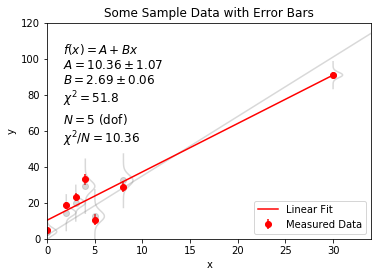

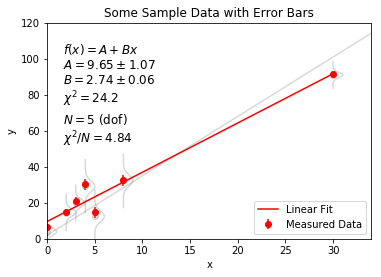

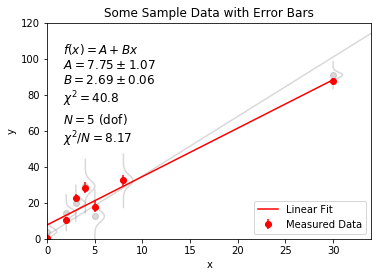

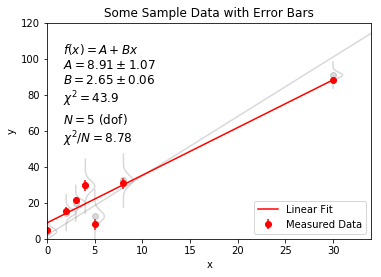

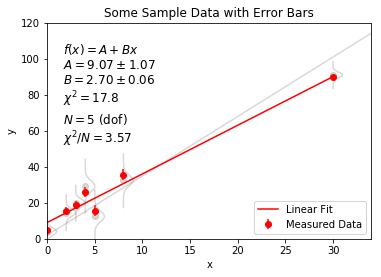

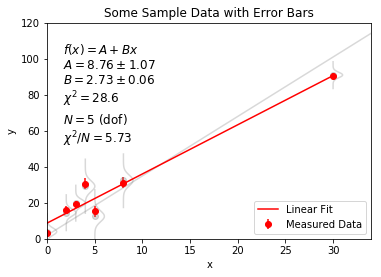

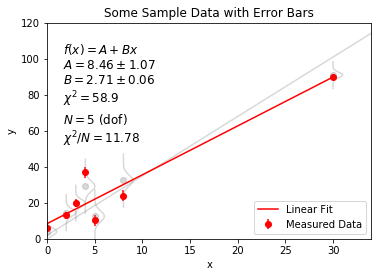

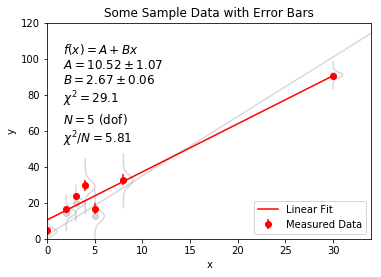

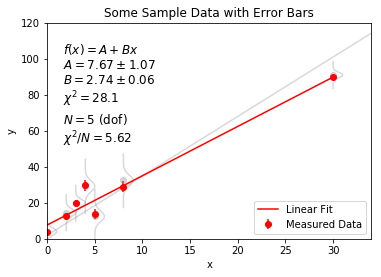

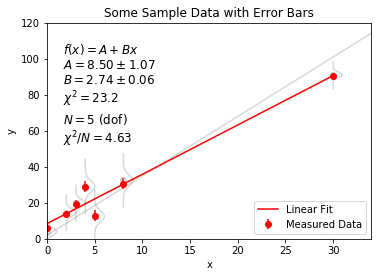

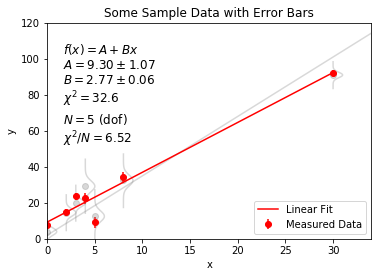

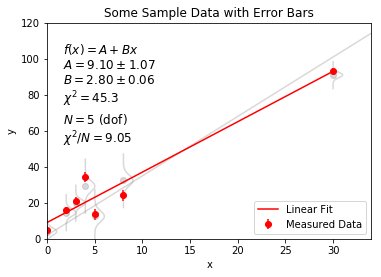

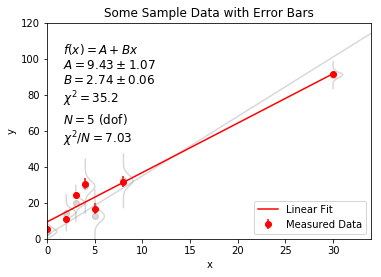

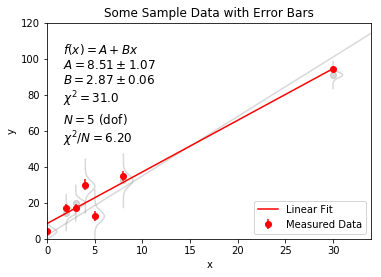

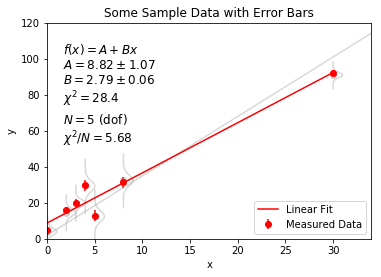

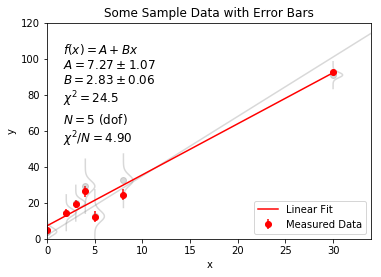

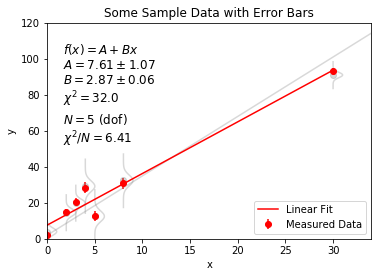

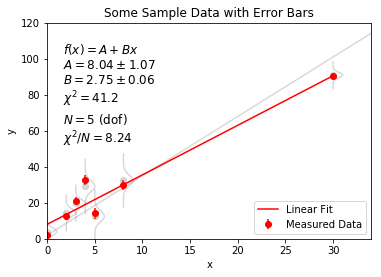

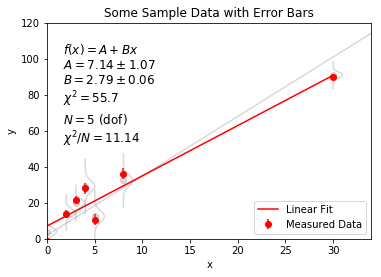

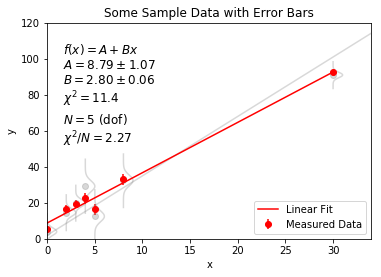

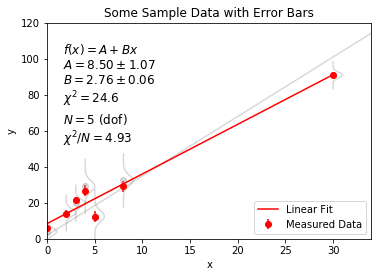

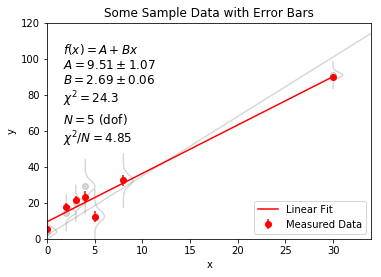

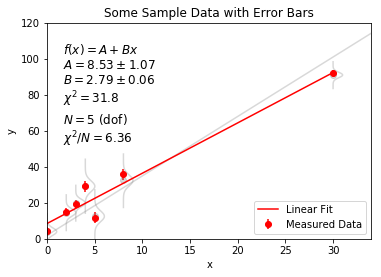

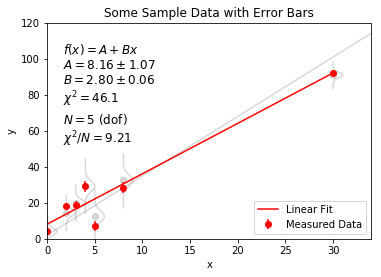

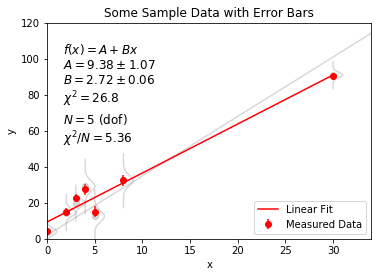

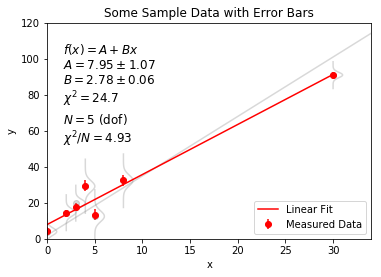

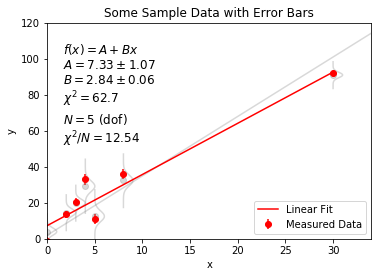

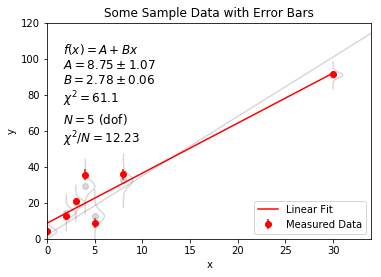

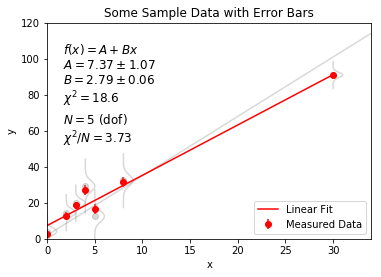

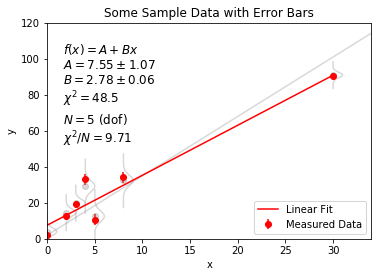

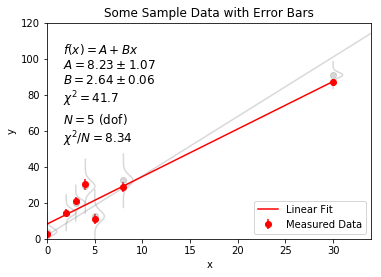

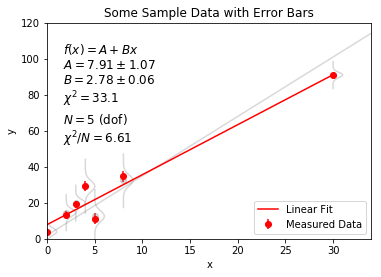

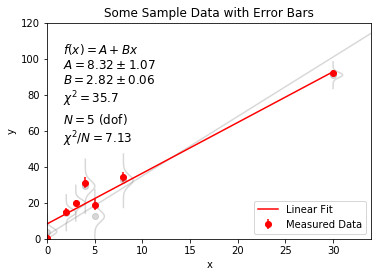

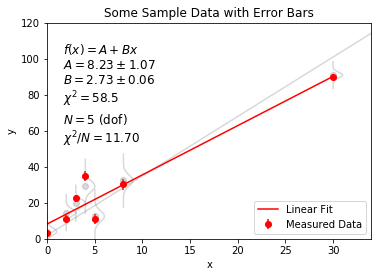

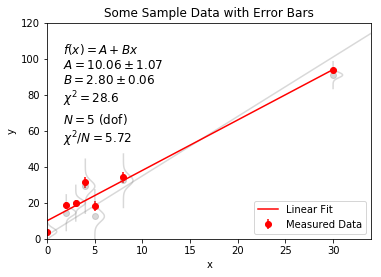

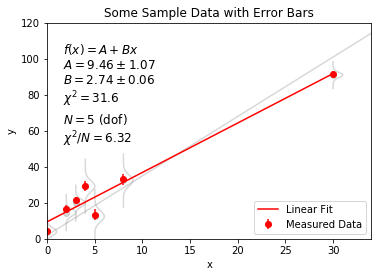

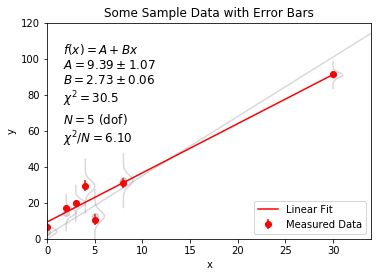

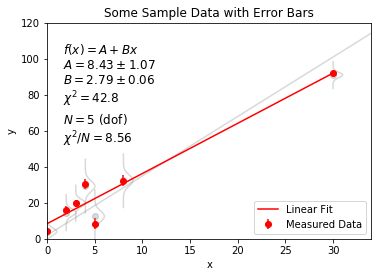

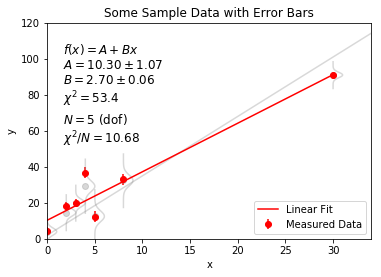

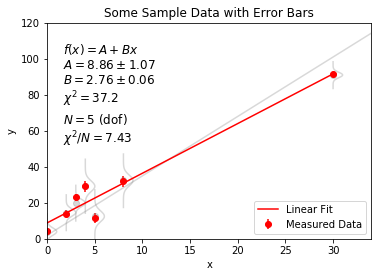

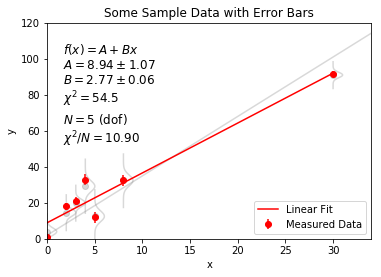

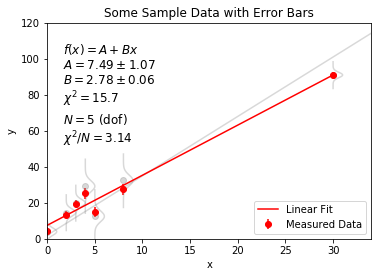

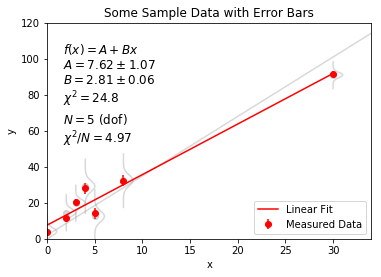

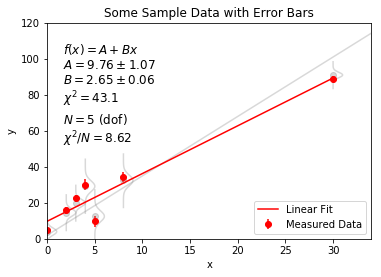

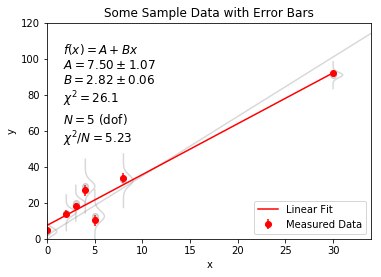

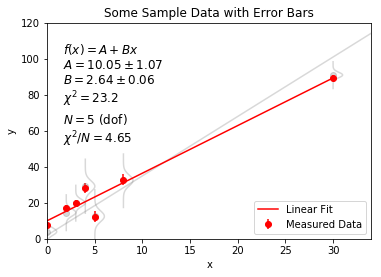

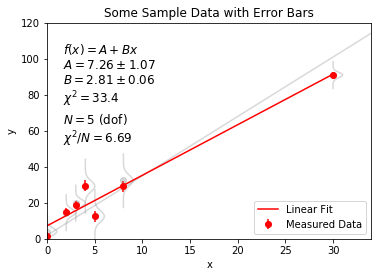

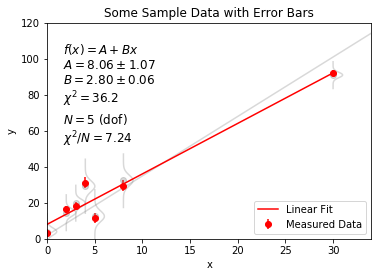

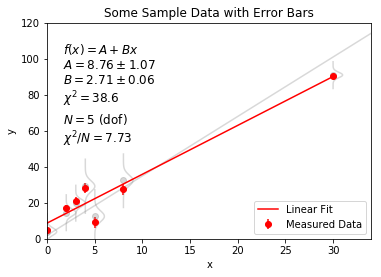

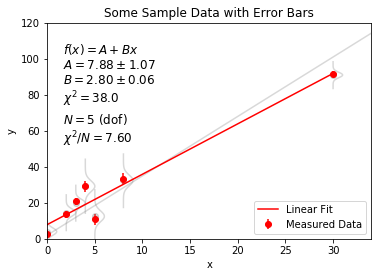

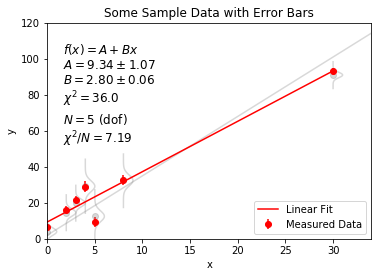

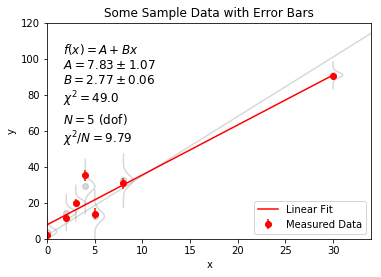

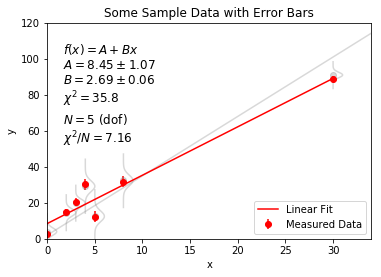

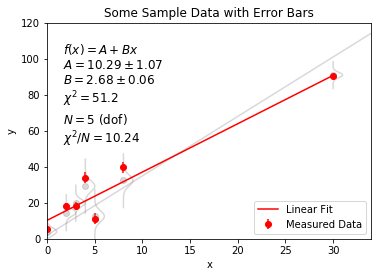

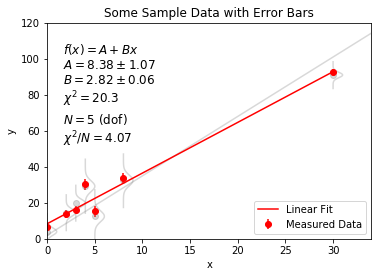

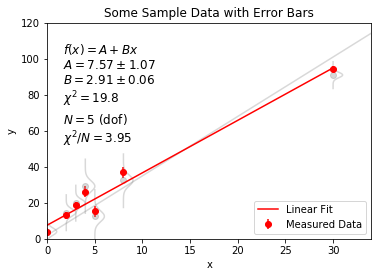

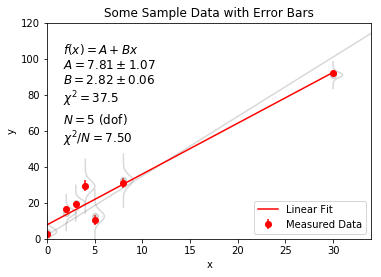

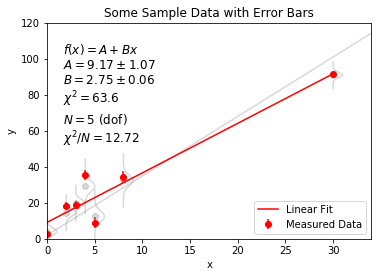

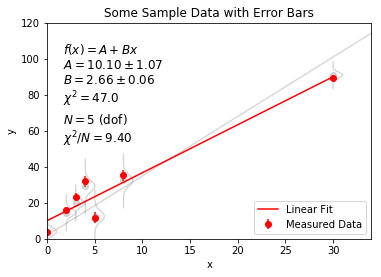

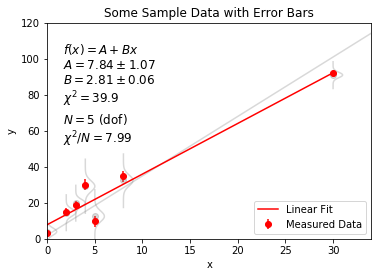

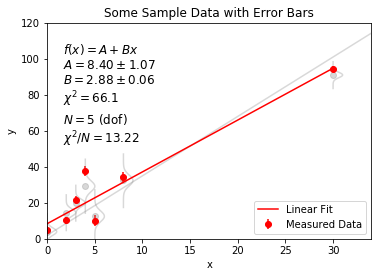

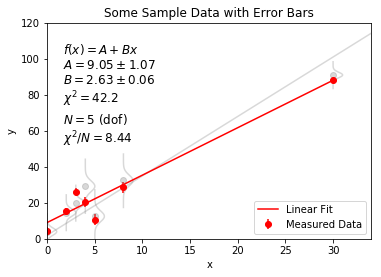

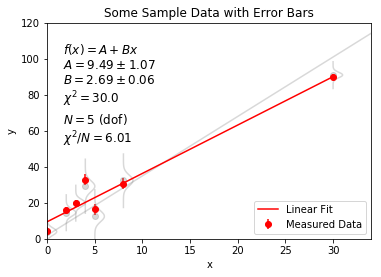

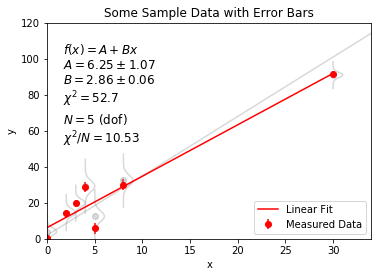

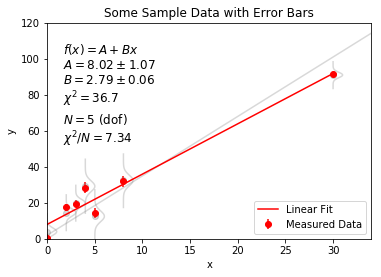

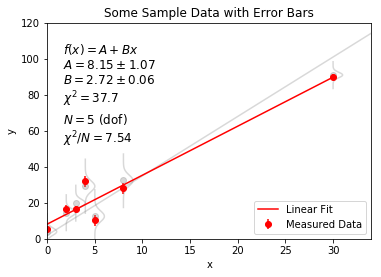

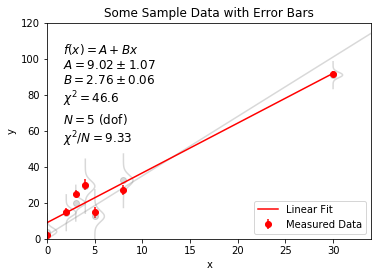

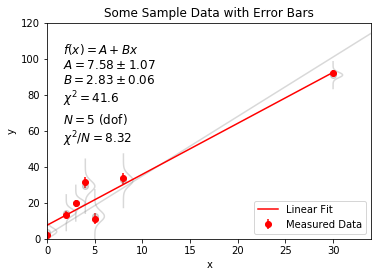

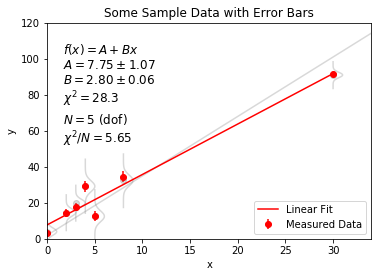

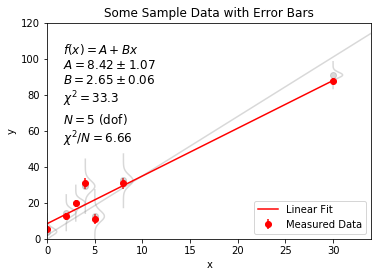

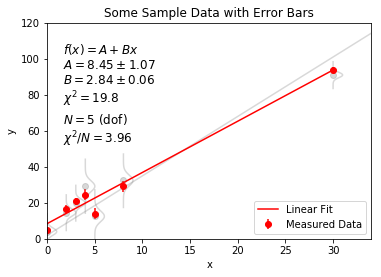

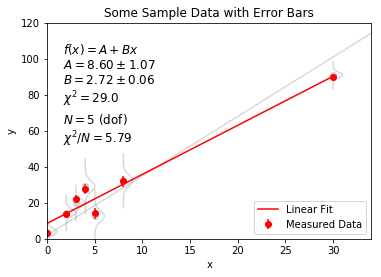

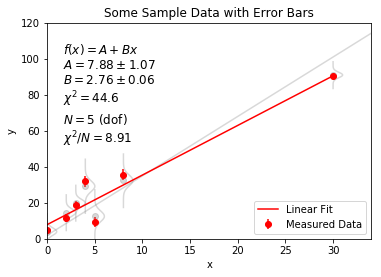

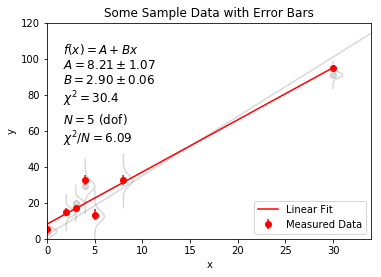

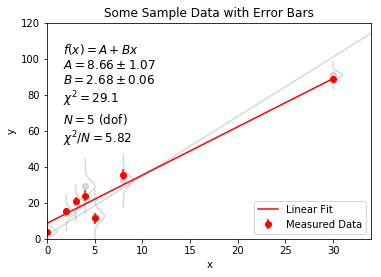

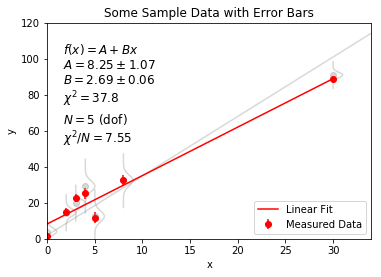

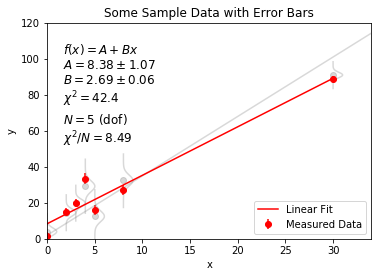

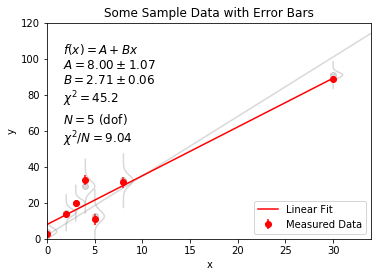

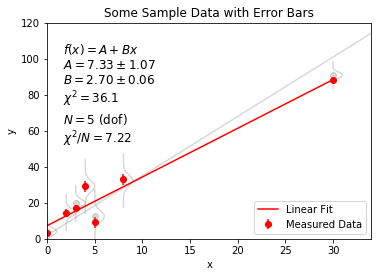

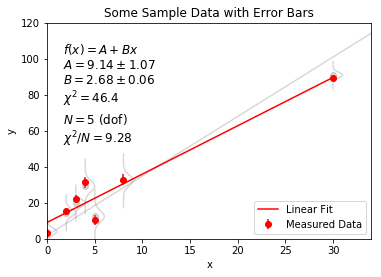

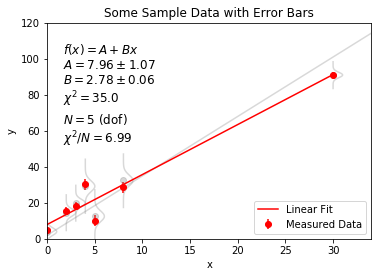

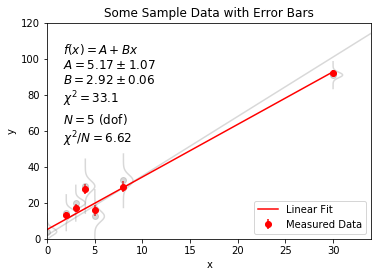

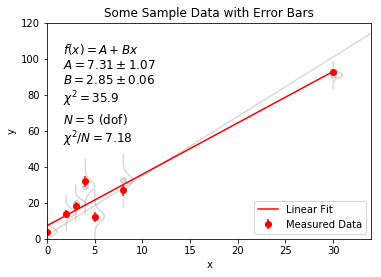

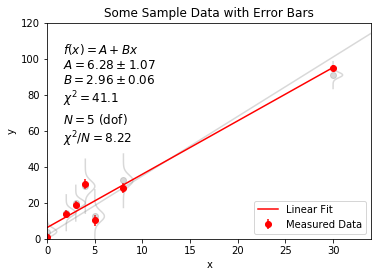

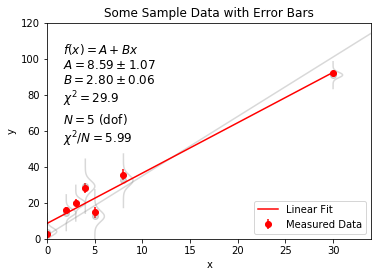

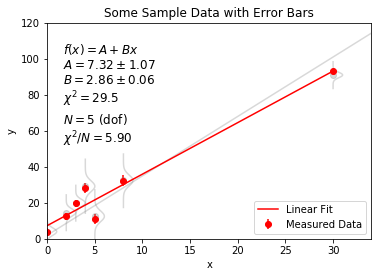

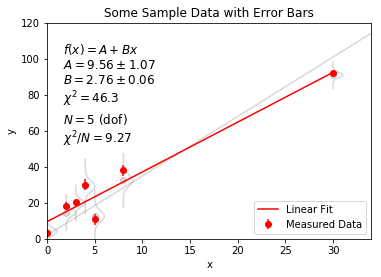

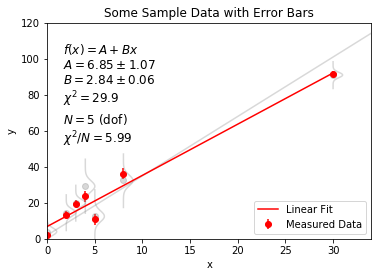

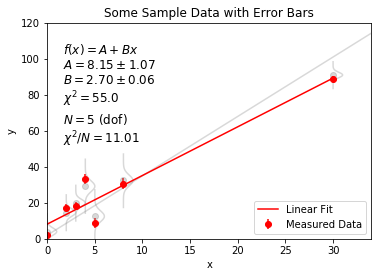

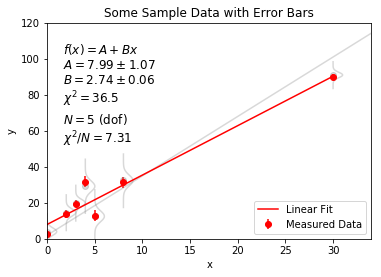

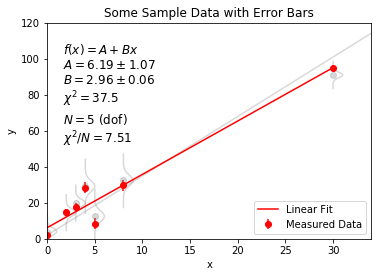

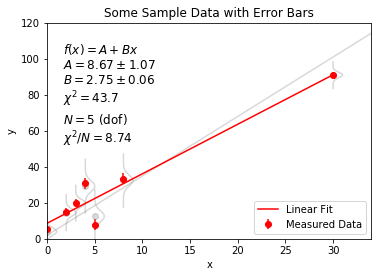

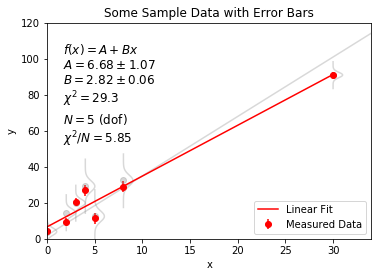

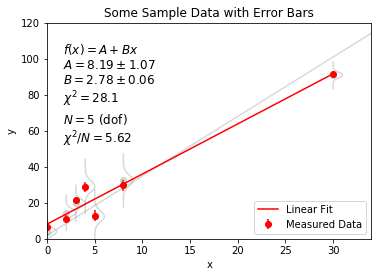

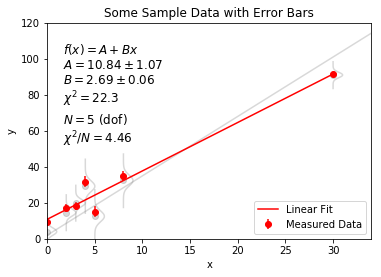

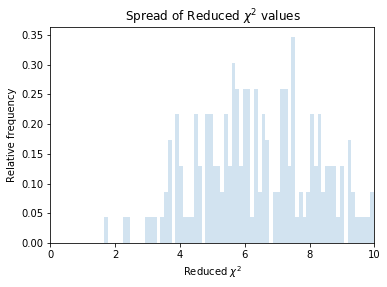

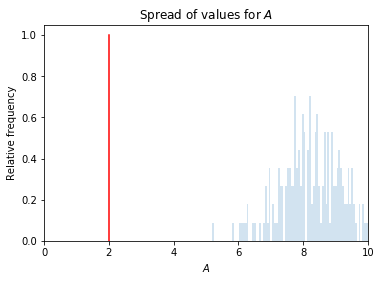

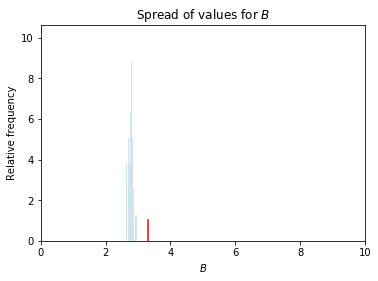

In [7]:
# generate images for movie
for rr in 1+np.arange(200):
    
    yvalues, ee     = mockdata(xvalues, true_error, func)
    yvalues_nominal = yvalues
    yvalues_syst    = yvalues + systs
    
    pf, cov, info, mesg, success = optimize.leastsq(func_residual, p0, args=(xvalues, yy, estimated_error), full_output=1)
    chisq = sum(info["fvec"]*info["fvec"])
    dof   = len(xvalues)-len(pf)
    pferr = []
    for i in range(len(pf)):
        pferr.append(np.sqrt(cov[i,i]))


    fig = plt.figure()
    fig.patch.set_facecolor('w')
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75]) 


    # text for reporting fit paramaters
    textfit = '$f(x) = A + Bx$ \n' \
            '$A = %.2f \pm %.2f$ \n' \
            '$B = %.2f \pm %.2f$ \n' \
            '$\chi^2= %.1f$ \n' \
            '$N = %i$ (dof) \n' \
            '$\chi^2/N = % .2f$' \
            % (pf[0], pferr[0], pf[1], pferr[1],
                chisq, dof, chisq/dof)

    # plot the perfect line
    xarray = np.arange(0,50)
    ax.plot(xarray,func(xarray),'-',color='gray',alpha=0.3)
    
    if rr==1:
        
        ax.annotate('physical law (y=2+3.3*x)', xy=(12, func(12)), xytext=(18, 38), 
                arrowprops=dict(facecolor='gray', shrink=0.11))
        
        ax.annotate('distributions from which measurements are drawn', xy=(8, func(8)+4), xytext=(3, 100), 
                arrowprops=dict(facecolor='gray', shrink=0.11))
    
        # plot the pdfs of the underlying data
        for xi,tei in zip(xvalues,true_error):
            yi = func(xi)
            yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
            xarray = xi+gauss(yyy,yi,tei,1)
            ax.plot(xarray,yyy,'-',color='gray',alpha=0.3)
            ax.plot(xi,yi,'o',color='gray',alpha=0.3, label = '')
            
    if rr==2:
              
        ax.text(3,100,'add systematic errors')
    
        # plot the pdfs of the underlying data
        for xi,tei,ssi in zip(xvalues,true_error,ss):
            yo = func(xi)
            yi = func(xi) + ssi
            yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
            xxx = xi+gauss(yyy,yi,tei,1)
            ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
            ax.plot(xi,yi,'o',color='gray',alpha=0.3, label='')
            ax.annotate('', xy=(xi,yi), xytext=(xi, yo), 
            arrowprops=dict(facecolor='green',arrowstyle="->"))

    elif rr==3:
        ax.text(3,100,'draw points from these distributions')
    
        # plot the pdfs of the underlying data
        for xi,tei,ssi in zip(xvalues,true_error,ss):
            yo = func(xi)
            yi = func(xi) + ssi
            yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
            xxx = xi+gauss(yyy,yi,tei,1)
            ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
            ax.plot(xi,yi,'o',color='gray',alpha=0.3, label='')
        
        l2 = ax.plot(xvalues, yy, 'ro', label = 'Measured Data')
        
    elif rr==4:
        
        # plot the pdfs of the underlying data
        for xi,tei,ssi in zip(xvalues,true_error,ss):
            yo = func(xi)
            yi = func(xi) + ssi
            yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
            xxx = xi+gauss(yyy,yi,tei,1)
            ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
            ax.plot(xi,yi,'o',color='gray',alpha=0.3)
        
        ax.text(3,100,'estimate errors')

        l2 = ax.errorbar(xvalues, yy, ee, fmt='ro', label = 'Measured Data')

        
    elif rr==5:
        
        # plot the pdfs of the underlying data
        for xi,tei,ssi in zip(xvalues,true_error,ss):
            yi = func(xi) + ssi
            yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
            xxx = xi+gauss(yyy,yi,tei,1)
            ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
            ax.plot(xi,yi,'o',color='gray',alpha=0.3)
        
        
        #plot fitted line
        l3 = ax.plot(xvalues, linear(pf, xvalues), 'r-', label = 'Linear Fit')
        
        ax.annotate('fitted law', xy=(22, func(22)-1), xytext=(24, 40), 
                arrowprops=dict(facecolor='red', shrink=0.))
        
        ax.annotate('fit parameters', xy=(10,90), xytext=(15, 100), 
                arrowprops=dict(facecolor='red', shrink=0.))
        
        ax.text(0.05, .90, textfit, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    
        # Now let's plot the data and the fit at the same time
        #l1 = ax.errorbar(xvalues, yy0, ee, fmt='ko', label = 'Unbiased Data',alpha=0.3)
        l2 = ax.errorbar(xvalues, yy, estimated_error, fmt='ro', label = 'Measured Data')
    

    
    elif rr>5:
        
        # plot the pdfs of the underlying data
        for xi,tei,ssi in zip(xvalues,true_error,ss):
            yi = func(xi) + ssi
            yyy = np.arange(yi-5*tei,yi+5*tei,10*tei/100.)
            xxx = xi+gauss(yyy,yi,tei,1)
            ax.plot(xxx,yyy,'-',color='gray',alpha=0.3)
            ax.plot(xi,yi,'o',color='gray',alpha=0.3)
        # Now let's plot the data and the fit at the same time
        #l1 = ax.errorbar(xvalues, yy0, ee, fmt='ko', label = 'Unbiased Data',alpha=0.3)
        l2 = ax.errorbar(xvalues, yy, estimated_error, fmt='ro', label = 'Measured Data')
    

        #plot fitted line
        l3 = ax.plot(xvalues, linear(pf, xvalues), 'r-', label = 'Linear Fit')

        #l4 = ax.errorbar(xx+0.1, yy, estimated_error, fmt='gx', label = 'Estimated Error')
        
        
        ax.text(0.05, .90, textfit, transform=ax.transAxes, fontsize=12,verticalalignment='top')
    
        
      
    ax.set_title('Some Sample Data with Error Bars')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax.set_xlim([0,34])
    ax.set_ylim([0,120])

    ax.legend(loc=4)

    
    display.clear_output(wait=True)
    display.display(fig.canvas.draw())
    
    #fig.canvas.draw()
    #fig.savefig('fit'+ str('%.3d' % rr) + '.png')
    #plt.close(fig)
    
    results.append([chisq/dof,pf[0], pf[1]])
    
 
resultsarray = np.array(results)

fig = plt.figure()
fig.patch.set_facecolor('w')
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75]) 

ax.hist(resultsarray[:,0], bins=int(np.size(resultsarray[:,0])/2), alpha=0.2, normed=True)

ax.set_title('Spread of Reduced $\chi^2$ values')
ax.set_xlabel('Reduced $\chi^2$')
ax.set_ylabel('Relative frequency')

ax.set_xlim([0,10])

display.clear_output(wait=True)
display.display(fig.canvas.draw())

#fig.canvas.draw()
rr=rr+1
#fig.savefig('fit'+ str('%.3d' % rr) + '.png')
#plt.close(fig)


fig = plt.figure()
fig.patch.set_facecolor('w')
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75]) 

ax.hist(resultsarray[:,1], bins=int(np.size(resultsarray[:,0])/2), alpha=0.2, normed=True)

ax.plot([p0[0],p0[0]],[0,1],'-r')

ax.set_title('Spread of values for $A$')
ax.set_xlabel('$A$')
ax.set_ylabel('Relative frequency')

ax.set_xlim([0,10])

display.clear_output(wait=True)
display.display(fig.canvas.draw())

#fig.canvas.draw()
rr=rr+1
#fig.savefig('fit'+ str('%.3d' % rr) + '.png')
#plt.close(fig)


fig = plt.figure()
fig.patch.set_facecolor('w')
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75]) 

ax.hist(resultsarray[:,2], bins=int(np.size(resultsarray[:,0])/2), alpha=0.2, normed=True)

ax.plot([p0[1],p0[1]],[0,1],'-r')

ax.set_title('Spread of values for $B$')
ax.set_xlabel('$B$')
ax.set_ylabel('Relative frequency')

ax.set_xlim([0,10])

display.clear_output(wait=True)
display.display(fig.canvas.draw())

#fig.canvas.draw()
rr=rr+1
#fig.savefig('fit'+ str('%.3d' % rr) + '.png')
#plt.close(fig)


In [ ]:
from pandas import *
import matplotlib.pyplot as plt
from numpy import random as rng
import time
from IPython import display
%matplotlib inline

ys = rng.randint(0, 5, (50, 5))
x_ax = [0,1,2,3,4]

for y_ax in ys:
    ts = Series(y_ax,index=x_ax)
    ts.plot(kind='bar', figsize=(15,5))
    display.clear_output(wait=True)
    display.display(plt.show())

<IPython.core.display.Javascript object>


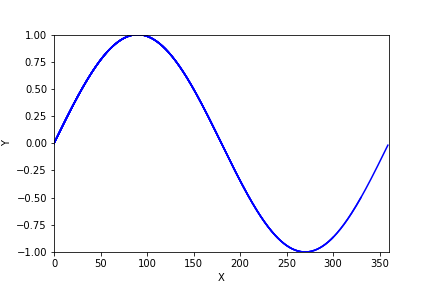

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time

def plt_dynamic(x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('X') ; ax.set_ylabel('Y')
ax.set_xlim(0,360) ; ax.set_ylim(-1,1)
xs, ys = [], []

# this is any loop for which you want to plot dynamic updates.
# in my case, I'm plotting loss functions for neural nets
for x in range(360):
    y = np.sin(x*np.pi/180)
    xs.append(x)
    ys.append(y)
    if x % 30 == 0:
        plt_dynamic(xs, ys, ax)
        time.sleep(.2)
plt_dynamic(xs, ys, ax)